## Modelagem Sísmica da Equação da Onda Acústica

A modelagem sísmica consiste na simulação numérica da propagação do campo de ondas com base na equação da onda acústica.

__Resultado esperado deste exemplo:__ registro de um sismograma referente a uma aquisição de spread fixo.


#### Características da implementação computacional

    - Discretização da derivadas parciais da equação da onda pelo Método das Diferenças Finitas
    
    - Ordem da discretição:
        > Derivadas espaciais: quarta ordem
        > Derivada temporal: segunda ordem
        
    - Atenuação do campo de ondas no contorno: metodologia proposta por Cerjan et al.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numba import jit

from velocity_models import *
from seismic_wavelets import ricker_wavelet

In [2]:
h = 10.0                                       # espaçamento da malha
dt = 0.001                                     # taxa de variação temporal

Ntotal = 3500                                  # tempo total discreto
cut_frequency = 30                             # frequencia de corte

Np   = 100                                     # numeros de pontos da camada de absorção para cada direção
Nx   = 300                                     # extensão do domínio
Nz   = 200                                     # profundidade do domínio

dimX = Np + Nx + Np                            # extensão do domínio mais contorno
dimZ = Np + Nz + Np                            # profundidade do domínio mais contorno


# posicionamento fonte sísmica
shot_x = Np + 150
shot_z = Np + 5
# posicionamento receptores
numberOfReceivers = 300
rec_x = range(Np, Np + numberOfReceivers)
rec_z = Np + 5        

In [3]:
# Paramentrização
print("----- PARAMETRIZAÇÃO ------")
print(f'Np: {Np}')
print(f'dimX: {dimX}   | dimZ: {dimZ}')
print(f'shot_x: {shot_x} | shot_z: {shot_z}')
print(f'rec_x: {rec_x[0]}  | rec_z: {rec_z}')

----- PARAMETRIZAÇÃO ------
Np: 100
dimX: 500   | dimZ: 400
shot_x: 250 | shot_z: 105
rec_x: 100  | rec_z: 105


In [4]:
seismic_source       = np.zeros(Ntotal)            # fonte sísmica
velocity             = np.zeros((dimZ, dimX))      # campo de velocidades
C                    = np.zeros((dimZ, dimX))      # matriz auxilar
    
wavefield01          = np.zeros((dimZ, dimX))      # campo de pressão em n - dt
wavefield02          = np.zeros((dimZ, dimX))      # campo de pressão em n
wavefield03          = np.zeros((dimZ, dimX))      # campo de pressão em n + dt

seismogram           = np.zeros((Ntotal, numberOfReceivers))    # sismograma

fa_s                 = np.empty(Np)                # perfil de atenuação superior
fa_i                 = np.empty(Np)                # perfil de atenuação inferior
fa_e                 = np.empty(Np)                # perfil de atenuação esquerdo
fa_d                 = np.empty(Np)                # perfil de atenuação direito

In [5]:
# definindo campo de velocidades
vel_layers = 2000.0
velocity = constant_velocity(vel_layers, dimX, dimZ)

# definindo a fonte sismica (ricker)
seismic_source = ricker_wavelet(cut_frequency, dt, Ntotal)

In [6]:
# coeficiente de diferencas finitas
c = (-5.0/2.0, 4.0/3.0, -1.0/12.0)

# matriz auxiliar Cik
for i in range(dimZ):
    for k in range(dimX):
        C[i, k] = (velocity[i, k] * (dt/h)) ** 2

In [7]:
# Cálculo dos fatores de atenuação
fat = 0.0025

for i in range(Np):
    fa_s[i] = exp(-((fat * (Np - i)) ** 2))

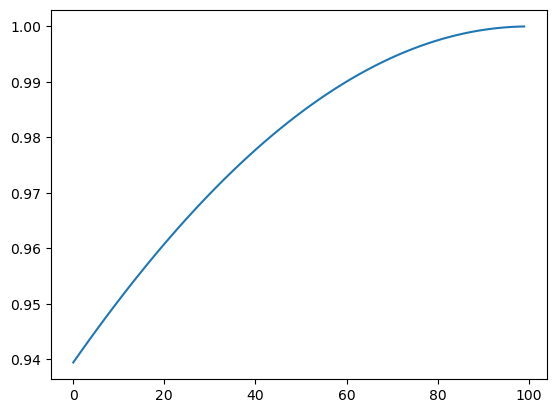

In [8]:
plt.plot(fa_s)

In [9]:
@jit
def wave_equation(wavefield01, wavefield02, wavefield03, C, c):
    for i in range(2, dimZ-2):
            for k in range(2, dimX-2):

                wavefield03[i,k] = C[i,k] * (2.0*c[0]*wavefield02[i, k] + 
                                             c[1]*(wavefield02[i,k-1] + wavefield02[i,k+1] + 
                                                   wavefield02[i-1,k] + wavefield02[i+1,k]) +
                                             c[2]*(wavefield02[i,k-2] + wavefield02[i,k+2] + 
                                                   wavefield02[i-2,k] + wavefield02[i+2,k])) + 2.0*wavefield02[i,k] - wavefield01[i,k]

C:\Users\chsba\AppData\Local\Temp\ipykernel_13908\4137363106.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def wave_equation(wavefield01, wavefield02, wavefield03, C, c):


In [10]:
@jit
def cerjan_atenuation(wavefield02, wavefield03, fa_s, dimX, dimZ):
    
    # Contorno superior
    for i in range(Np):
        for k in range(2, dimX - 2):
            wavefield02[i,k] = fa_s[i] * wavefield02[i,k]
            wavefield03[i,k] = fa_s[i] * wavefield03[i,k]

C:\Users\chsba\AppData\Local\Temp\ipykernel_13908\416274119.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cerjan_atenuation(wavefield02, wavefield03, fa_s, dimX, dimZ):


In [11]:
def seismic_modeling(wavefield01, wavefield02, wavefield03, 
                     C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismogram):
    
    for n in range(0, Ntotal):

        # calculo do campo de ondas
        wave_equation(wavefield01, wavefield02, wavefield03, C, c)
        
        # Atenuação do campo de ondas no contorno
        cerjan_atenuation(wavefield02, wavefield03, fa_s, dimX, dimZ)
        
        # registro do sismograma (aquisição spread fixo)
        for irec in range(len(rec_x)):
            seismogram[n, irec] = wavefield03[rec_z, rec_x[irec]]
        
        # fonte sísmica
        wavefield02[shot_z,shot_x] = wavefield02[shot_z,shot_x] + seismic_source[n]*(velocity[shot_z,shot_x]**2)
        
        
        # Atualização do campo de onda
        wavefield01 = np.copy(wavefield02)
        wavefield02 = np.copy(wavefield03)

        if n % 1000 == 0:
            print(n)

In [12]:
seismic_modeling(wavefield01, wavefield02, wavefield03, 
                                  C, c, seismic_source, shot_x, shot_z, Ntotal, rec_x, rec_z, seismogram)

0
1000
2000
3000


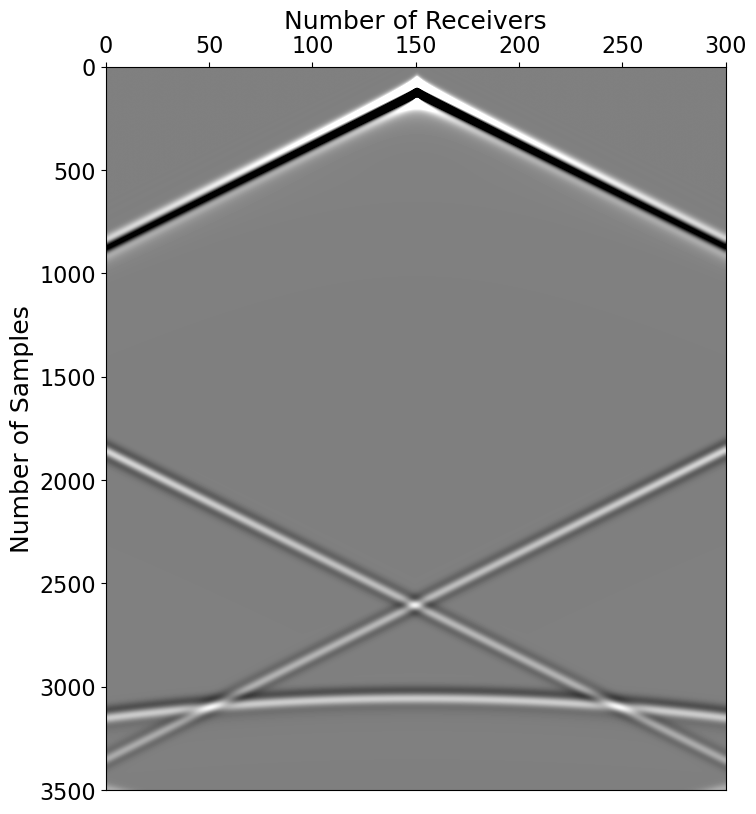

In [13]:
from data_plotting import plotting_seismogram

image_name = "seismogram.png"
plotting_seismogram(Ntotal, numberOfReceivers, seismogram, image_name)